# Imports

In [1]:
import os

import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
%%capture

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *

# Choose indicator by uncommenting one of the following lines
# indicator = 'calcium'
indicator = 'glutamate'

database.connect_dj(indicator=indicator)

In [3]:
rf_kind, rf_fit_kind = database.get_default_rf_and_rf_fit_kind()

rf_tab = database.get_rf_tab(inc_nl=False)
lchirp_tab = database.get_lchirp_tab(quality_filter=False)
gchirp_tab = database.get_gchirp_tab(quality_filter=False)
sinespot_tab = database.get_sinespot_tab(quality_filter=False)
morph_tab = database.get_morph_tab()

## Cell and ROI selection

In [4]:
import pickle

with open(f"cell_and_rois_{indicator}.json", "rb") as file:
    cell_and_rois = pickle.load(file)

In [5]:
palettes = {}

for (cell, rois), colormap in zip(
        cell_and_rois.items(),
        ['Oranges_r', 'Blues_r', 'Greens_r'] if indicator == 'calcium' else ['Oranges_r', 'Greens_r']
):
    palettes[cell] = sns.color_palette(colormap, n_colors=1 + len(rois))

# Plot

In [6]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [7]:
FIGURE_FOLDER = 'figures'

In [8]:
from djimaging.utils.trace_utils import find_closest
from alphaanalysis.plot.receptive_field import fetch_srf_outline


def plot_trace(ax, stim, date, exp_num, field_id, roi_id, c='k', lw=0.8, alpha=1.):
    stim = stim.lower()

    # Make case-insensitive
    key = [dict(date=date, exp_num=exp_num, roi_id=roi_id, field=f"d{field_id}"),
           dict(date=date, exp_num=exp_num, roi_id=roi_id, field=f"d{field_id}")]

    if stim in ['sinespot', 'lchirp', 'gchirp']:
        if stim == 'sinespot':
            trace, trace_time = (sinespot_tab & key).fetch1("average", "average_times")
            trace_time = trace_time + Snippets._delay['sinespot']
            idxa, idxb, idxc = 0, find_closest(1., trace_time, as_index=True), find_closest(2., trace_time,
                                                                                            as_index=True)
            trace_time, trace = trace_time[idxa:idxc], trace[idxa:idxc]

        elif stim == 'lchirp':
            trace, trace_time = (lchirp_tab & key).fetch1("average", "average_times")
        elif stim == 'gchirp':
            trace, trace_time = (gchirp_tab & key).fetch1("average", "average_times")
        else:
            raise NotImplementedError(stim)
        ax.plot(trace_time, trace, color=c, lw=lw, alpha=alpha)

        if stim == 'gchirp':
            plota.lines(ax, ts=(2, 5, 8, 30,), orientation='v')
        elif stim == 'sinespot':
            plota.lines(ax, ts=(0, 1,), orientation='v')

        if 'chirp' in stim:
            ax.set_xticks([0, 30])

    elif stim == 'trf':
        trf = (rf_tab & key).fetch1("trf")

        try:
            rf_time = (rf_tab & key).fetch1('rf_time')
        except dj.DataJointError:
            model_dict = (rf_tab & key).fetch1('model_dict')

            if "rf_time" in model_dict:
                rf_time = model_dict['rf_time']
            else:
                dt, rf = (rf_tab & key).fetch1('dt', 'rf')
                n_t = rf.shape[0]
                shift = model_dict['shift']
                rf_time = (-np.arange(n_t) * dt - shift['stimulus'] * dt)[::-1]

        rf_time = -rf_time

        ax.invert_xaxis()
        ax.plot(rf_time, trf, c=c, lw=lw, alpha=alpha)
        plota.lines(ax, ts=(0,), orientation='h')
        plota.lines(ax, ts=(0,), orientation='v')

    elif stim == 'srf':
        srf = (rf_tab & key).fetch1("srf")
        srf_outline = fetch_srf_outline(key, rf_tab, rf_fit_kind)
        vabsmax = np.max(np.abs(srf))
        plota.plot_srf(ax, srf=srf, srf_outline=srf_outline, vabsmax=vabsmax, plot_outline=True,
                       outline_kw=dict(alpha=0.8, lw=0.5))

        if indicator == 'glutamate':
            dx = 30
            dy = -20
            ax.set_xlim(-112.5 + dx, 112.5 + dx)
            ax.set_ylim(-150 + dy, 150 + dy)
            plota.plot_scale_bar(ax, x0=-112.5 + 20 + dx, y0=-150 + 20 + dy, size=100)
        else:
            plota.plot_scale_bar(ax, x0=-(15 * 30) / 2 + 10, y0=-(20 * 30) / 2 + 10, size=100)

## Traces and ROIs

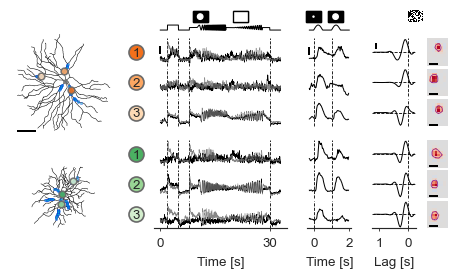

In [9]:
DEBUG = False

stim_order = ['chirp', 'sinespot', 'tRF', 'sRF']
width_ratios = [2.5, 0.2, 3, 1, 1, 1]
height_ratios = []

mosaic = []
mosaic.append(['.', '.'] + ['chirp_spatial', 'sinespot_spatial', 'noise_spatial', 'noise_spatial'])
height_ratios.append(0.4)
mosaic.append(['.', '.'] + ['chirp', 'sinespot', 'noise', 'noise'])
height_ratios.append(0.2)

mosaic.append(['.'] * (len(stim_order) + 2))
height_ratios.append(0.1)

for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    for j, highlight_roi in enumerate(highlight_list):
        mosaic.append([f'M{i}', f'R_{i}_{j}'] + [f'{stim}_{i}_{j}' for stim in stim_order])
        height_ratios.append(1)
    mosaic.append(['.'] * (len(stim_order) + 2))
    height_ratios.append(0.3)

fig, axs = plt.subplot_mosaic(
    mosaic, figsize=(4.0, 0.61 + 0.255 * len(np.concatenate(list(cell_and_rois.values())))) if not DEBUG else (8, 8),
    width_ratios=width_ratios, height_ratios=height_ratios)

for ax in axs.values():
    if not DEBUG:
        ax.axis('off')

plt.tight_layout(h_pad=0.2, w_pad=1.0)

# Plot stim
plota.plot_sinespot(axs['sinespot'], c='k', lw=0.6, clip_on=False, delay=Snippets._delay['sinespot'])
plota.plot_spot_spatial(axs['sinespot_spatial'], s_list=[60, 300], w=800, h=600, space=400)

plota.plot_chirp(axs['chirp'], c='k', lw=0.6, clip_on=False, tmax=33)
plota.plot_spot_spatial(axs['chirp_spatial'], s_list=[300, 1000], w=800, h=600, space=1400)

plota.plot_noise(axs['noise_spatial'])
#axs['noise'].text(0.5, 0.5, '5 Hz', ha='center', va='center')

# Plot morphologies
morph_axs = []
for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    plota.plot_rois_on_morph(
        axs[f'M{i}'], cell, highlight_list, rf_fit_kind,
        morph_tab, rf_tab, FieldPosMetrics.RoiPosMetrics, FieldCalibratedStackPos.RoiCalibratedStackPos, LineStack,
        FieldStackPos, Field, Experiment,
        annotate=False, plot_srf_contours=False, plot_srf_offset=False, plot_rf_rois_only=False,
        palettes=palettes,
        roi_kws=dict(ms=3, alpha=0.5, mew=0.25, mec='b')
    )
    morph_axs.append(axs[f'M{i}'])
    if i == 0 or DEBUG:
        plota.plot_scale_bar(axs[f'M{i}'], x0=50, y0=0, size=100, pad=-10, text='', orientation='h')
plota.make_share_ylims(morph_axs)

# Plot roi highlights
for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
    for j, (field_id, roi_id) in enumerate(highlight_list):
        axs[f'R_{i}_{j}'].plot(0.5, 0.5, marker='o', ms=9, c=palettes[(date, exp_num)][j + 1], mec='dimgray',
                               clip_on=False)
        axs[f'R_{i}_{j}'].text(0.5, 0.47, f"{j + 1}", ha='center', va='center')
        axs[f'R_{i}_{j}'].set(xlim=(0, 1), ylim=(0, 1))

# Plot responses
for stim in stim_order:
    stim_axs = []
    for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
        for j, (field_id, roi_id) in enumerate(highlight_list):
            stim_names = [stim] if stim != 'chirp' else ['gChirp', 'lChirp']
            for stim_name in stim_names:
                plot_trace(
                    axs[f'{stim}_{i}_{j}'], stim_name, date, exp_num, field_id, roi_id,
                    c='dimgray' if stim_name == 'lChirp' else 'k',
                    alpha=0.8 if stim_name == 'lChirp' else 1.,
                    lw=0.3 if stim == 'chirp' else 0.6,
                )
                stim_axs.append(axs[f'{stim}_{i}_{j}'])
    plota.make_share_ylims(stim_axs)

# Vertical scale bars
plota.plot_scale_bar(axs[f'chirp_0_0'], x0=0, y0=1, size=2, pad=-10, text='', orientation='v')
plota.plot_scale_bar(axs[f'sinespot_0_0'], x0=-0.25, y0=0., size=2, pad=-10, text='', orientation='v')
plota.plot_scale_bar(axs[f'tRF_0_0'], x0=1.1, y0=0.25, size=0.5, pad=-10, text='', orientation='v')

for stim in ['chirp', 'sinespot']:
    plota.make_share_xlims([axs[stim]] + [
        axs[f'{stim}_{i}_{j}']
        for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items())
        for j, (field_id, roi_id) in enumerate(highlight_list)])

for stim in ['tRF', 'chirp', 'sinespot']:
    for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
        if i == len(cell_and_rois) - 1:
            ax = axs[f'{stim}_{len(cell_and_rois) - 1}_{len(highlight_list) - 1}']
            ax.axis('on')
            [ax.spines[kind].set_visible(False) for kind in ['top', 'left', 'right']]
            ax.set(ylabel=None, yticks=[], xlabel='Lag [s]' if stim == 'tRF' else 'Time [s]')

# Fine tuning
plota.move_box([axs[k] for k in axs.keys() if 'trf' in k.lower()], dx=+0.03)
plota.move_box(axs['noise_spatial'], dx=+0.015)

plota.move_box([axs[k] for k in axs.keys() if 'sinespot' in k.lower()], dx=+0.015)
plota.move_box(axs['sinespot_spatial'], dx=-0.01)

morph_axes = [axs[k] for k in axs.keys() if k.startswith('M') and len(k) == 2]
space = 0.07
plota.change_box(morph_axes, dx=space, dy=space)
plota.move_box(morph_axes, dx=-space / 2, dy=-space / 2)

if indicator == 'glutamate':
    fig.savefig(os.path.join(FIGURE_FOLDER, f'example_rois_{indicator}.pdf'), bbox_inches='tight')

## Alternative

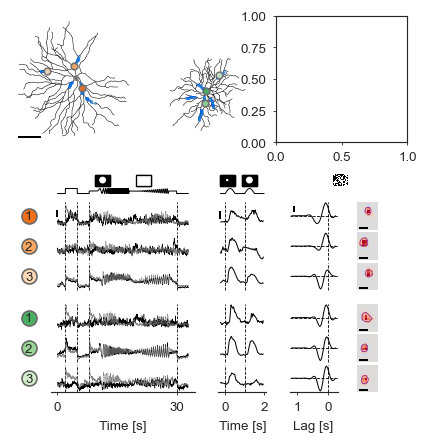

In [10]:
DEBUG = False

stim_order = ['chirp', 'sinespot', 'tRF', 'sRF']
width_ratios = [0.2, 3, 1, 1, 1]
height_ratios = []

mosaic = []
mosaic.append(['.'] + ['chirp_spatial', 'sinespot_spatial', 'noise_spatial', 'noise_spatial'])
height_ratios.append(0.4)
mosaic.append(['.'] + ['chirp', 'sinespot', 'noise', 'noise'])
height_ratios.append(0.2)

mosaic.append(['.'] * (len(stim_order) + 1))
height_ratios.append(0.1)

for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    for j, highlight_roi in enumerate(highlight_list):
        mosaic.append([f'R_{i}_{j}'] + [f'{stim}_{i}_{j}' for stim in stim_order])
        height_ratios.append(1)
    mosaic.append(['.'] * (len(stim_order) + 1))
    height_ratios.append(0.3)

fig, axs = plt.subplot_mosaic(
    mosaic, figsize=(3.3, 3.3) if not DEBUG else (8, 8), width_ratios=width_ratios, height_ratios=height_ratios)

for ax in axs.values():
    if not DEBUG:
        ax.axis('off')

plt.tight_layout(h_pad=0.2, w_pad=1.3, rect=(0, 0, 1, 0.65))

top_gs = fig.add_gridspec(nrows=1, ncols=3, left=0.03, right=0.97, top=0.98, bottom=0.73)

# Create axes in the new gridspec
for i in range(3):
    axs[f'M{i}'] = fig.add_subplot(top_gs[0, i])

# Plot stim
plota.plot_sinespot(axs['sinespot'], c='k', lw=0.6, clip_on=False, delay=Snippets._delay['sinespot'])
plota.plot_spot_spatial(axs['sinespot_spatial'], s_list=[60, 300], w=800, h=600, space=400)

plota.plot_chirp(axs['chirp'], c='k', lw=0.6, clip_on=False, tmax=33)
plota.plot_spot_spatial(axs['chirp_spatial'], s_list=[300, 1000], w=800, h=600, space=1400)

plota.plot_noise(axs['noise_spatial'])
#axs['noise'].text(0.5, 0.5, '5 Hz', ha='center', va='center')

# Plot morphologies
morph_axs = []
for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    plota.plot_rois_on_morph(
        axs[f'M{i}'], cell, highlight_list, rf_fit_kind,
        morph_tab, rf_tab, FieldPosMetrics.RoiPosMetrics, FieldCalibratedStackPos.RoiCalibratedStackPos, LineStack,
        FieldStackPos, Field, Experiment,
        annotate=False, plot_srf_contours=False, plot_srf_offset=False, plot_rf_rois_only=False,
        palettes=palettes,
        roi_kws=dict(ms=3, alpha=0.5, mew=0.25, mec='b')
    )
    morph_axs.append(axs[f'M{i}'])
    if i == 0:
        plota.plot_scale_bar(axs[f'M{i}'], x0=50, y0=0, size=100, pad=-10, text='', orientation='h')
plota.make_share_ylims(morph_axs)

# Plot roi highlights
for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
    for j, (field_id, roi_id) in enumerate(highlight_list):
        axs[f'R_{i}_{j}'].plot(0.5, 0.5, marker='o', ms=9, c=palettes[(date, exp_num)][j + 1], mec='dimgray',
                               clip_on=False)
        axs[f'R_{i}_{j}'].text(0.5, 0.47, f"{j + 1}", ha='center', va='center')
        axs[f'R_{i}_{j}'].set(xlim=(0, 1), ylim=(0, 1))

# Plot responses
for stim in stim_order:
    stim_axs = []
    for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
        for j, (field_id, roi_id) in enumerate(highlight_list):
            stim_names = [stim] if stim != 'chirp' else ['gChirp', 'lChirp']
            for stim_name in stim_names:
                plot_trace(
                    axs[f'{stim}_{i}_{j}'], stim_name, date, exp_num, field_id, roi_id,
                    c='dimgray' if stim_name == 'lChirp' else 'k',
                    alpha=0.8 if stim_name == 'lChirp' else 1.,
                    lw=0.3 if stim == 'chirp' else 0.6,
                )
                stim_axs.append(axs[f'{stim}_{i}_{j}'])
    plota.make_share_ylims(stim_axs)

# Vertical scale bars
plota.plot_scale_bar(axs[f'chirp_0_0'], x0=0, y0=1, size=2, pad=-10, text='', orientation='v')
plota.plot_scale_bar(axs[f'sinespot_0_0'], x0=-0.25, y0=0., size=2, pad=-10, text='', orientation='v')
plota.plot_scale_bar(axs[f'tRF_0_0'], x0=1.1, y0=0.25, size=0.5, pad=-10, text='', orientation='v')

for stim in ['chirp', 'sinespot']:
    plota.make_share_xlims([axs[stim]] + [
        axs[f'{stim}_{i}_{j}']
        for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items())
        for j, (field_id, roi_id) in enumerate(highlight_list)])

for stim in ['tRF', 'chirp', 'sinespot']:
    for i, ((date, exp_num), highlight_list) in enumerate(cell_and_rois.items()):
        if i == len(cell_and_rois) - 1:
            ax = axs[f'{stim}_{len(cell_and_rois) - 1}_{len(highlight_list) - 1}']
            ax.axis('on')
            [ax.spines[kind].set_visible(False) for kind in ['top', 'left', 'right']]
            ax.set(ylabel=None, yticks=[], xlabel='Lag [s]' if stim == 'tRF' else 'Time [s]')

# Fine tuning
plota.move_box([axs[k] for k in axs.keys() if 'trf' in k.lower()], dx=+0.03)
plota.move_box(axs['noise_spatial'], dx=+0.015)

plota.move_box([axs[k] for k in axs.keys() if 'sinespot' in k.lower()], dx=+0.015)
plota.move_box(axs['sinespot_spatial'], dx=-0.01)

morph_axes = [axs[k] for k in axs.keys() if k.startswith('M') and len(k) == 2]
space = 0.07
plota.change_box(morph_axes, dx=space, dy=space)
plota.move_box(morph_axes, dx=-space / 2, dy=-space / 2)

if indicator == 'calcium':
    fig.savefig(os.path.join(FIGURE_FOLDER, f'example_rois_{indicator}.pdf'))